# Dogs vs. Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2

In [2]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

## Функции загрузки данных

In [28]:
import os
from random import shuffle
from glob import glob

train_files = glob('dogs-vs-cats-redux-kernels-edition/train/*.jpg')
test_files = glob('dogs-vs-cats-redux-kernels-edition/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    i = 0
    while True:
        for path in files:
            i += 1
#             print(i, ' из ', len(test_files))
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

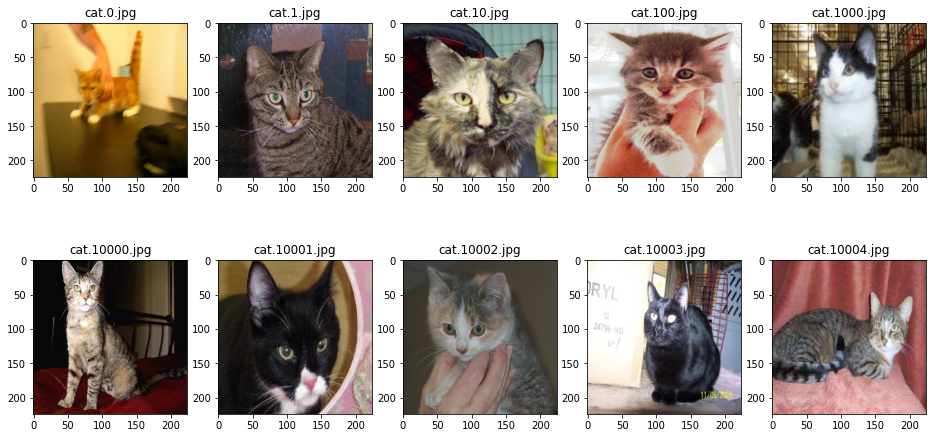

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('\\')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Загружаем предобученную модель

In [5]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [6]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

In [7]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Добавляем BatchNormalization и полносвязный слой

In [13]:
x = base_model.layers[-1].output
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1,  # один выход
                activation='sigmoid',  # функция активации  
                )(x)

model = Model(inputs=base_model.input, outputs=x)

In [14]:
# фиксируем веса предобученной сети
for layer in model.layers:
    layer.trainable = False
# эти не фиксируем
for layer in model.layers[-5:]:
    layer.trainable = True

## Выводим архитектуру модели

In [15]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## Компилируем модель и запускаем обучение

In [16]:
model.compile(optimizer='sgd',  # keras.optimizers.Adam(lr=1e-5), 
                loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss)
              metrics=['accuracy'])

In [17]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке
validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
model.fit(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=25,        # число эпох обучения
        validation_data=validation_data)

Epoch 1/25
10/10 [==============================] - 29s 3s/step - loss: 0.3952 - accuracy: 0.8199 - val_loss: 0.1433 - val_accuracy: 0.9600
Epoch 2/25
10/10 [==============================] - 32s 3s/step - loss: 0.2181 - accuracy: 0.9170 - val_loss: 0.0503 - val_accuracy: 0.9700
Epoch 3/25
10/10 [==============================] - 33s 3s/step - loss: 0.0940 - accuracy: 0.9425 - val_loss: 0.0376 - val_accuracy: 0.9800
Epoch 4/25
10/10 [==============================] - 33s 3s/step - loss: 0.0884 - accuracy: 0.9753 - val_loss: 0.0524 - val_accuracy: 0.9700
Epoch 5/25
10/10 [==============================] - 33s 3s/step - loss: 0.0904 - accuracy: 0.9752 - val_loss: 0.0214 - val_accuracy: 0.9900
Epoch 6/25
10/10 [==============================] - 33s 3s/step - loss: 0.0594 - accuracy: 0.9758 - val_loss: 0.0389 - val_accuracy: 0.9900
Epoch 7/25
10/10 [==============================] - 33s 3s/step - loss: 0.0436 - accuracy: 0.9798 - val_loss: 0.0228 - val_accuracy: 0.9900
Epoch 8/25
10/10 [==

In [18]:
model.save('dogs-vs-cats-redux-kernels-edition/cats-dogs-vgg16_v3.hdf5')

## Предсказания на проверочной выборке

In [29]:
pred = model.predict(predict_generator(test_files), steps=len(test_files))

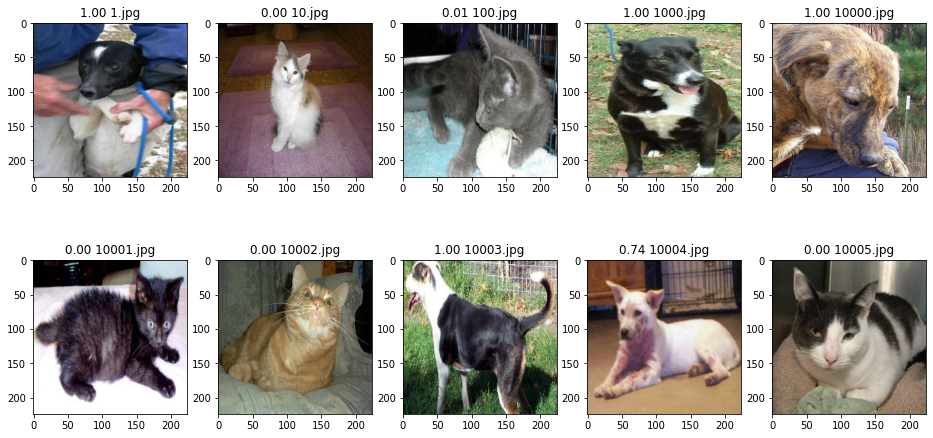

In [30]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовим данные для отправки

In [32]:
import re

with open('dogs-vs-cats-redux-kernels-edition/submission_dogs_cats.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

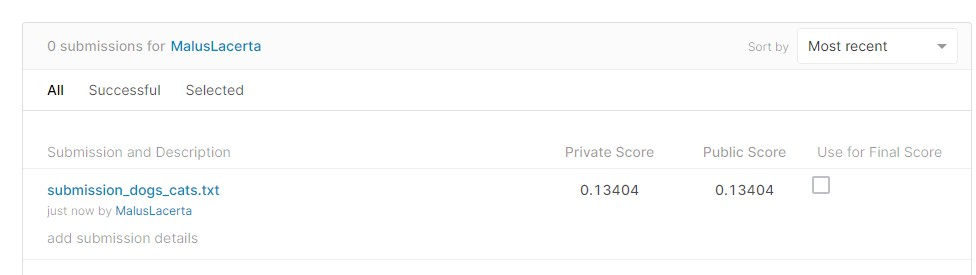

In [33]:
from IPython.display import Image
Image('dogs-vs-cats-redux-kernels-edition/kaggle_dogs_cats.jpg')